In [1]:
import glob
import os
import random
from collections import Counter

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm

# Preprocessing

## Stats

In [2]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images", 
             unit="img", dynamic_ncols=True) as pbar:
        
        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue
                
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")
                        
                    img = img.astype(np.float32) / 255.0
                    
                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])
                    
                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))
                    
                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]
    
    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")
    
    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

In [3]:
root_dir_dataset = r'Dataset/All'
mean, std = calculate_dataset_stats(root_dir_dataset)

dataset_mean = [round(float(m), 5) for m in mean]
dataset_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_mean)
print("Dataset Std (RGB):", dataset_std)

assert all(0 <= m <= 1 for m in dataset_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_std), "Std values out of [0,1] range"

if (abs(mean[0]*255 - 0.485 * 255) < 0.01):
    print("Red mean mismatch")
if (abs(mean[1]*255 - 0.456 * 255) < 0.01):
    print("Green mean mismatch")
if (abs(mean[2]*255 - 0.406 * 255) < 0.01):
    print("Blue mean mismatch")

if (abs(std[0]*255 - 0.229 * 255) < 0.01):
    print("Red std mismatch")
if (abs(std[1]*255 - 0.224 * 255) < 0.01):
    print("Green std mismatch")
if (abs(std[2]*255 - 0.225 * 255) < 0.01):
    print("Blue std mismatch")

print("\nBasic validation checks passed!")

Processing Images: 100%|██████████| 9000/9000 [00:41<00:00, 216.26img/s, Processed=9000, Errors=0, Current=turn_right]               


Validation Summary:
Total images attempted: 9000
Successfully processed: 9000
Problematic files: 0

Dataset Statistics:
Dataset Mean (RGB): [0.48948, 0.48214, 0.53307]
Dataset Std (RGB): [0.21354, 0.2212, 0.20459]

Basic validation checks passed!


In [4]:
def get_image_analysis(image_path):
    analysis = {}
    
    analysis['path'] = image_path
    analysis['filesize'] = os.path.getsize(image_path)
    analysis['modified_time'] = os.path.getmtime(image_path)
    
    try:
        with Image.open(image_path) as img:
            analysis['format'] = img.format
            analysis['mode'] = img.mode
            analysis['size'] = img.size
            analysis['info'] = img.info
            
        img_cv = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img_cv is not None:
            analysis['dtype'] = img_cv.dtype
            analysis['shape'] = img_cv.shape
            analysis['channels'] = img_cv.shape[2] if len(img_cv.shape) > 2 else 1
            
            analysis['stats'] = {
                'min': img_cv.min(),
                'max': img_cv.max(),
                'mean': img_cv.mean(),
                'std': img_cv.std(),
                'unique': len(np.unique(img_cv))
            }
            
            import hashlib
            analysis['md5'] = hashlib.md5(img_cv.tobytes()).hexdigest()
            
            analysis['has_alpha'] = (img_cv.shape[2] == 4) if len(img_cv.shape) > 2 else False
            
        return analysis
    except Exception as e:
        analysis['error'] = str(e)
        return analysis

def visualize_image(analysis):
    img = cv2.imread(analysis['path'])
    if img is None:
        return

    display_text = [
        f"Size: {analysis['size'][0]}x{analysis['size'][1]}",
        f"Channels: {analysis['channels']}",
        f"Mode: {analysis['mode']}",
        f"Type: {analysis['dtype']}",
        f"Range: {analysis['stats']['min']}-{analysis['stats']['max']}",
        f"Mean: {analysis['stats']['mean']:.1f} ± {analysis['stats']['std']:.1f}"
    ]

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.text(0.5, -0.1, '\n'.join(display_text),
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.axis('off')
    plt.show()

def analyze_dataset(dataset_root, sample_per_folder=1, save_report=False):
    report = []
    
    for root, dirs, files in os.walk(dataset_root):
        if not files:
            continue
            
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        samples = image_files[:sample_per_folder]
        
        for img_file in samples:
            img_path = os.path.join(root, img_file)
            analysis = get_image_analysis(img_path)
            report.append(analysis)
            

            print(f"\nClass: {os.path.basename(root)}")
            print(f"Image: {img_file}")
            print("-"*40)
            for k, v in analysis.items():
                if k == 'exif': continue
                if k == 'info': continue
                print(f"{k:>15}: {v}")
                
            if 'error' not in analysis:
                visualize_image(analysis)
            else:
                print(f"Error processing image: {analysis['error']}")
    
    if save_report:
        with open('dataset_analysis_report.txt', 'w') as f:
            for entry in report:
                f.write(f"{'-'*40}\n")
                for k, v in entry.items():
                    f.write(f"{k:>15}: {v}\n")
    
    return report


dataset_path = r"Dataset/All"
analyze_dataset(dataset_path, sample_per_folder=1)


Class: barred_area
Image: 00_00_00003.png
----------------------------------------
           path: Dataset/All\barred_area\00_00_00003.png
       filesize: 249583
  modified_time: 1744407177.815377
         format: PNG
           mode: RGB
           size: (288, 288)
          dtype: uint8
          shape: (288, 288, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(229), 'mean': np.float64(125.98586194701646), 'std': np.float64(49.232280346062346), 'unique': 226}
            md5: 39819fc6c3824a4dc61bd87ae0982773
      has_alpha: False


: 

## Data Augmentation

In [15]:
dataset_mean = [0.48948, 0.48214, 0.53307]
dataset_std = [0.21354, 0.2212, 0.20459]

img_size = 32

In [10]:
transform_album = A.Compose([
        A.Resize(32, 32),
        # A.LongestMaxSize(max_size=32, interpolation=cv2.INTER_LINEAR, p=1.0),
        # A.PadIfNeeded(
        #     min_height=32,
        #     min_width=32,
        #     border_mode=cv2.BORDER_CONSTANT,
        #     p=1.0),
        A.Affine(
            scale=(0.95, 1.05),
            shear=(-5, 5),
            fill=0,
            p=0.7),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_CONSTANT,
            fill=0,
            p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.5, 0.5),
            contrast_limit=(-0.2, 0.2),
            p=0.8),
        A.RGBShift(
            r_shift_limit=(-10, 10),
            g_shift_limit=(-10, 10),
            b_shift_limit=(-10, 10),
            p=0.8),
        A.MotionBlur(
            blur_limit=(5, 7),
            p=0.3),
        A.GaussNoise(
            std_range=(0.01, 0.02),
            p=0.3),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std),
            max_pixel_value=255.0,
            normalization="standard",
            p=1.0),
        ToTensorV2(p=1.0)
    ])

In [11]:
transform_simple = A.Compose([
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std),
            max_pixel_value=255.0,
            normalization="standard",
            p=1.0),
        ToTensorV2(p=1.0)
    ])

In [12]:
transform_resize = A.Compose([
        A.Resize(32, 32),
        ToTensorV2(p=1.0)
    ])

In [13]:
root_dir_train = r'Dataset/Train'
root_dir_augmented = r'Dataset/Augmented'
os.makedirs(root_dir_augmented, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir_train)
                      if os.path.isdir(os.path.join(root_dir_train, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir_train, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

### Train Augmentation

In [14]:
pbar = tqdm(total=len(images_path_list) * augmentation_count, 
            desc="Augmenting Images", 
            unit="img", 
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(root_dir_augmented, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']
        
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_std) + np.array(dataset_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)
        
        new_filename = f"{base_name}_{aug_num:02d}.png"
        new_path = os.path.join(root_dir_augmented, class_name, new_filename)
        
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue
        
        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(root_dir_augmented, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(root_dir_augmented)}")

Augmenting Images: 100%|██████████| 18360/18360 [01:30<00:00, 202.84img/s, Processing: turn_right/11_01_00440_05.png]



Augmentation complete. 3672 → 18360 files
Augmented images saved in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset\Augmented


### Normalized Test

In [17]:
root_dir_test = r'Dataset/Test'

images_path_list = []
for class_name in os.listdir(root_dir_test):
    class_path = os.path.join(root_dir_test, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir_test)}")

Processing Images: 100%|██████████| 4428/4428 [00:40<00:00, 110.55img/s]


Processing complete. 4428 images replaced
Original images overwritten in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset\Test


### Normalized Val

In [18]:
root_dir_val = r'Dataset/Val'

images_path_list = []
for class_name in os.listdir(root_dir_val):
    class_path = os.path.join(root_dir_val, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir_val)}")

Processing Images:   0%|          | 0/900 [00:00<?, ?img/s]

Processing Images: 100%|██████████| 900/900 [00:07<00:00, 126.15img/s]


Processing complete. 900 images replaced
Original images overwritten in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset\Val


## Dataset Class

In [19]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.class_names = sorted(list(set(os.path.basename(os.path.dirname(p)) for p in images_path_list)))
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            import cv2
            image = cv2.imread(path)
            if image is None:
                raise ValueError("Image could not be read")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    from PIL import Image
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                from albumentations.pytorch import ToTensorV2
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 32, 32)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [20]:
class TrafficSignDBNPY(Dataset):
    def __init__(self, X_npy_path, y_npy_path, transform=None):
        if isinstance(X_npy_path, (str, bytes, os.PathLike)):
            self.X = np.load(X_npy_path)
        else:
            self.X = X_npy_path

        if isinstance(y_npy_path, (str, bytes, os.PathLike)):
            self.y = np.load(y_npy_path)
        else:
            self.y = y_npy_path
            
        self.transform = transform
        self.y_int = np.argmax(self.y, axis=1)
        
        self.class_names = [
            'barred_area',
            'cross_walk',
            'go_straight',
            'no_passing_zone_beginning',
            'parking_zone',
            'priority_over',
            'steep_hill_downhill',
            'steep_hill_uphill',
            'stop',
            'tunnel_beginning',
            'turn_left',
            'turn_right'
        ]
        self.idx_to_class = self._create_label_mapping()

    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        path = self.X[index]
        label = int(self.y_int[index])
        
        if self.transform:
            image = path.transpose(1, 2, 0)
            transformed = self.transform(image=image)
            image = transformed["image"]
        else:
            image = torch.from_numpy(path)
        
        return image, label
    
    def get_class_name(self, label_idx):
        return self.class_names[label_idx] if label_idx < len(self.class_names) else "unknown"

## Train/Test List and NPY

In [21]:
img_size = 32

root_dir = r'Dataset'
root_dir_train = r'Dataset/Train'
root_dir_test = r'Dataset/Test'
root_dir_val = r'Dataset/Val'

images_path_list_train = []
labels_path_list_train = []

images_path_list_test = []
labels_path_list_test = []

images_path_list_val = []
labels_path_list_val = []

class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir_train)
                      if os.path.isdir(os.path.join(root_dir_train, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    
    # Train images (Augmented)
    train_pattern = os.path.join(root_dir_train, class_name, "*.png")
    train_images_paths = glob.glob(train_pattern)
    np.random.shuffle(train_images_paths)
    for train_path in train_images_paths:
        images_path_list_train.append(train_path)
        labels_path_list_train.append(cls_idx)

    # Test images
    test_pattern = os.path.join(root_dir_test, class_name, "*.png")
    test_images_paths = glob.glob(test_pattern)
    np.random.shuffle(test_images_paths)
    for test_path in test_images_paths:
        images_path_list_test.append(test_path)
        labels_path_list_test.append(cls_idx)
    
    # Validation images
    val_pattern = os.path.join(root_dir_val, class_name, "*.png")
    val_images_paths = glob.glob(val_pattern)
    np.random.shuffle(val_images_paths)
    for val_path in val_images_paths:
        images_path_list_val.append(val_path)
        labels_path_list_val.append(cls_idx)

In [23]:
total_train = len(images_path_list_train)
total_test = len(images_path_list_test)
total_val = len(images_path_list_val)
total_all = total_train + total_test

perc_train = total_train / total_all * 100
perc_test = total_test / total_all * 100

print("Final dataset sizes:")
print(f"Training: {total_train} samples ({perc_train:.2f}%)")
print(f"Testing: {total_test} samples ({perc_test:.2f}%)")
print(f"Validation: {total_val} samples")

train_counts = Counter(labels_path_list_train)
test_counts = Counter(labels_path_list_test)
val_counts = Counter(labels_path_list_val)

print("\nTraining Class Distribution:")
for idx in sorted(train_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {train_counts[idx]} samples")

print("\nTesting Class Distribution:")
for idx in sorted(test_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {test_counts[idx]} samples")

print("\nValidation Class Distribution:")
for idx in sorted(val_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {val_counts[idx]} samples")

Final dataset sizes:
Training: 18360 samples (80.57%)
Testing: 4428 samples (19.43%)
Validation: 900 samples

Training Class Distribution:
Class 'barred_area' (Index 0): 1530 samples
Class 'cross_walk' (Index 1): 1530 samples
Class 'go_straight' (Index 2): 1530 samples
Class 'no_passing_zone_beginning' (Index 3): 1530 samples
Class 'parking_zone' (Index 4): 1530 samples
Class 'priority_over' (Index 5): 1530 samples
Class 'steep_hill_downhill' (Index 6): 1530 samples
Class 'steep_hill_uphill' (Index 7): 1530 samples
Class 'stop' (Index 8): 1530 samples
Class 'tunnel_beginning' (Index 9): 1530 samples
Class 'turn_left' (Index 10): 1530 samples
Class 'turn_right' (Index 11): 1530 samples

Testing Class Distribution:
Class 'barred_area' (Index 0): 369 samples
Class 'cross_walk' (Index 1): 369 samples
Class 'go_straight' (Index 2): 369 samples
Class 'no_passing_zone_beginning' (Index 3): 369 samples
Class 'parking_zone' (Index 4): 369 samples
Class 'priority_over' (Index 5): 369 samples
Cla

In [25]:
if ('images_path_list_train' in globals() and 
    'images_path_list_test' in globals() and 
    'images_path_list_val' in globals()):
    
    train_files = set(images_path_list_train)
    test_files = set(images_path_list_test)
    val_files = set(images_path_list_val)
    
    dup_train_val = train_files.intersection(val_files)
    dup_train_test = train_files.intersection(test_files)
    dup_val_test = val_files.intersection(test_files)
    
    print("Duplicates between training and validation:", len(dup_train_val))
    print("Duplicates between training and test:", len(dup_train_test))
    print("Duplicates between validation and test:", len(dup_val_test))
else:
    print("File path lists not found; skipping duplicate check.")

Duplicates between training and validation: 0
Duplicates between training and test: 0
Duplicates between validation and test: 0


In [26]:
def one_hot_encoder(labels, num_classes):
    encoded = np.zeros((len(labels), num_classes), dtype=np.float32)
    encoded[np.arange(len(labels)), labels] = 1.0
    return encoded

In [27]:
def process_img_npy(image_paths, labels, save_dir, dataset_type, mean, std):
    os.makedirs(save_dir, exist_ok=True)
    X = []
    y = []
    
    mean_arr = np.array(mean, dtype=np.float32)
    std_arr = np.array(std, dtype=np.float32)
    
    for img_path, label in tqdm(zip(image_paths, labels), 
                              total=len(image_paths), 
                              desc=f"Processing {save_dir}"):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipping unreadable file: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            
            img = img.astype(np.float32) / 255.0
            img = (img - mean_arr) / std_arr
            
            img = np.transpose(img, (2, 0, 1))
            
            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Skipping corrupted file {img_path}: {e}")
    
    X = np.array(X, dtype=np.float32)
    y = one_hot_encoder(np.array(y, dtype=np.int64), num_classes=len(class_names))
    
    np.save(os.path.join(save_dir, f'X_{dataset_type}_data.npy'), X)
    np.save(os.path.join(save_dir, f'y_{dataset_type}_labels.npy'), y)
    print(f"X shape: {X.shape}, y shape: {y.shape}") 
    print(f"\nSaved {X.shape[0]} samples to {save_dir}\n")

In [28]:
process_img_npy(images_path_list_train,
                labels_path_list_train, 
               root_dir,
               'train',
               mean=dataset_mean,
               std=dataset_std)

process_img_npy(images_path_list_test,
                labels_path_list_test,
               root_dir,
               'test',
               mean=dataset_mean,
               std=dataset_std)

process_img_npy(images_path_list_val,
                labels_path_list_val,
               root_dir,
               'val',
               mean=dataset_mean,
               std=dataset_std)

print("\nDataset preprocessing complete!")
print(f"Final dataset sizes:")
print(f"- Training: {len(images_path_list_train)} samples")
print(f"- Testing: {len(images_path_list_test)} samples")
print(f"- Validation: {len(images_path_list_val)} samples")
print(f"One-hot encoded labels shape: ({len(class_names)} classes)")

Processing Dataset: 100%|██████████| 18360/18360 [03:56<00:00, 77.50it/s]


X shape: (18360, 3, 32, 32), y shape: (18360, 12)

Saved 18360 samples to Dataset



Processing Dataset: 100%|██████████| 4428/4428 [00:57<00:00, 77.15it/s]


X shape: (4428, 3, 32, 32), y shape: (4428, 12)

Saved 4428 samples to Dataset



Processing Dataset: 100%|██████████| 900/900 [00:11<00:00, 77.44it/s]

X shape: (900, 3, 32, 32), y shape: (900, 12)

Saved 900 samples to Dataset


Dataset preprocessing complete!
Final dataset sizes:
- Training: 18360 samples
- Testing: 4428 samples
- Validation: 900 samples
One-hot encoded labels shape: (12 classes)


# EDA

In [29]:
def load_npy_data(save_dir, type):
    X = np.load(os.path.join(save_dir, f'X_{type}_data.npy'))
    y = np.load(os.path.join(save_dir, f'y_{type}_labels.npy'))
    return X, y

X_train_npy, y_train_npy = load_npy_data(root_dir, 'train')
X_test_npy, y_test_npy = load_npy_data(root_dir, 'test')
X_val_npy, y_val_npy = load_npy_data(root_dir, 'val')

print("\nVerifying NPY file contents:")
print(f"\nTraining data shape: {X_train_npy.shape}")
print(f"Training labels shape: {y_train_npy.shape}")
print(f"\nTest data shape: {X_test_npy.shape}")
print(f"Test labels shape: {y_test_npy.shape}")
print(f"\nValidation data shape: {X_val_npy.shape}")
print(f"Validation labels shape: {y_val_npy.shape}")


Verifying NPY file contents:

Training data shape: (18360, 3, 32, 32)
Training labels shape: (18360, 12)

Test data shape: (4428, 3, 32, 32)
Test labels shape: (4428, 12)

Validation data shape: (900, 3, 32, 32)
Validation labels shape: (900, 12)


In [30]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def verify_dataset(dataset, class_names, data_dir=None, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    counts = Counter(dataset.y_int)
    class_labels = sorted(counts.keys())
    class_counts = [counts[cls] for cls in class_labels]
    
    print("\nClass Distribution Details:")
    for cls_idx in sorted(counts.keys()):
        print(f"{class_names[cls_idx]} (Index {cls_idx}): {counts[cls_idx]} samples")
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(
        x=class_labels, 
        y=class_counts, 
        hue=class_labels,
        palette="viridis",
        legend=False
    )
    plt.title("Class Distribution")
    plt.xlabel("Class Index")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    print("\nClass Distribution Summary:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Mean samples per class: {np.mean(class_counts):.1f}")
    print(f"Std samples per class: {np.std(class_counts):.1f}")
    
    plt.subplot(1, 2, 2)
    sample_idx = random.randint(0, len(dataset)-1)
    img, label = dataset[sample_idx]
    if isinstance(img, torch.Tensor):
        img_disp = denormalize_image(img, mean, std)
    else:
        img_disp = img.transpose(1, 2, 0)
    plt.imshow(img_disp)
    plt.title(f"Random Sample\nClass: {class_names[label]} (Idx: {label})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    plot_one_per_class(dataset, class_names, mean, std)
    
    if data_dir:
        plot_directory_samples(data_dir, class_names)

def plot_one_per_class(dataset, class_names, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    class_to_indices = {i: [] for i in range(len(class_names))}
    for idx, label in enumerate(dataset.y_int):
        class_to_indices[label].append(idx)
    
    chosen_indices = []
    for cls in sorted(class_to_indices.keys()):
        if class_to_indices[cls]:
            chosen_indices.append(random.choice(class_to_indices[cls]))
    
    plt.figure(figsize=(15, 10))
    cols = 6
    rows = (len(chosen_indices) + cols - 1) // cols
    
    for i, idx in enumerate(chosen_indices):
        plt.subplot(rows, cols, i+1)
        img, label = dataset[idx]
        if isinstance(img, torch.Tensor):
            img_disp = denormalize_image(img, mean, std)
        else:
            img_disp = img.transpose(1, 2, 0)
            img_disp = np.clip(img_disp, 0, 1)
        plt.imshow(img_disp)
        plt.title(f"{class_names[label]}\n(Idx: {label})", fontsize=8)
        plt.axis('off')
    
    plt.suptitle("One Random Sample per Class from Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_directory_samples(data_dir, class_names):
    train_dir = os.path.join(data_dir, 'Train')
    plt.figure(figsize=(15, 10))
    cols = 6
    rows = (len(class_names) + cols - 1) // cols
    for cls_idx, class_name in enumerate(class_names):
        plt.subplot(rows, cols, cls_idx+1)
        class_dir = os.path.join(train_dir, str(cls_idx))
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.endswith('.png')]
            if images:
                img_path = os.path.join(class_dir, random.choice(images))
                img = plt.imread(img_path)
                plt.imshow(img)
        plt.title(f"{class_name}\n(Idx: {cls_idx})", fontsize=8)
        plt.axis('off')
    plt.suptitle("Sample Images from Directory Structure", fontsize=14)
    plt.tight_layout()
    plt.show()

In [31]:
train_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_train_data.npy',
    y_npy_path=r'Dataset/y_train_labels.npy',
    transform=transform_resize
)

test_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_test_data.npy',
    y_npy_path=r'Dataset/y_test_labels.npy',
    transform=transform_resize
)

val_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_val_data.npy',
    y_npy_path=r'Dataset/y_val_labels.npy',
    transform=transform_resize
)


Class Distribution Details:
barred_area (Index 0): 1530 samples
cross_walk (Index 1): 1530 samples
go_straight (Index 2): 1530 samples
no_passing_zone_beginning (Index 3): 1530 samples
parking_zone (Index 4): 1530 samples
priority_over (Index 5): 1530 samples
steep_hill_downhill (Index 6): 1530 samples
steep_hill_uphill (Index 7): 1530 samples
stop (Index 8): 1530 samples
tunnel_beginning (Index 9): 1530 samples
turn_left (Index 10): 1530 samples
turn_right (Index 11): 1530 samples

Class Distribution Summary:
Total samples: 18360
Number of classes: 12
Mean samples per class: 1530.0
Std samples per class: 0.0


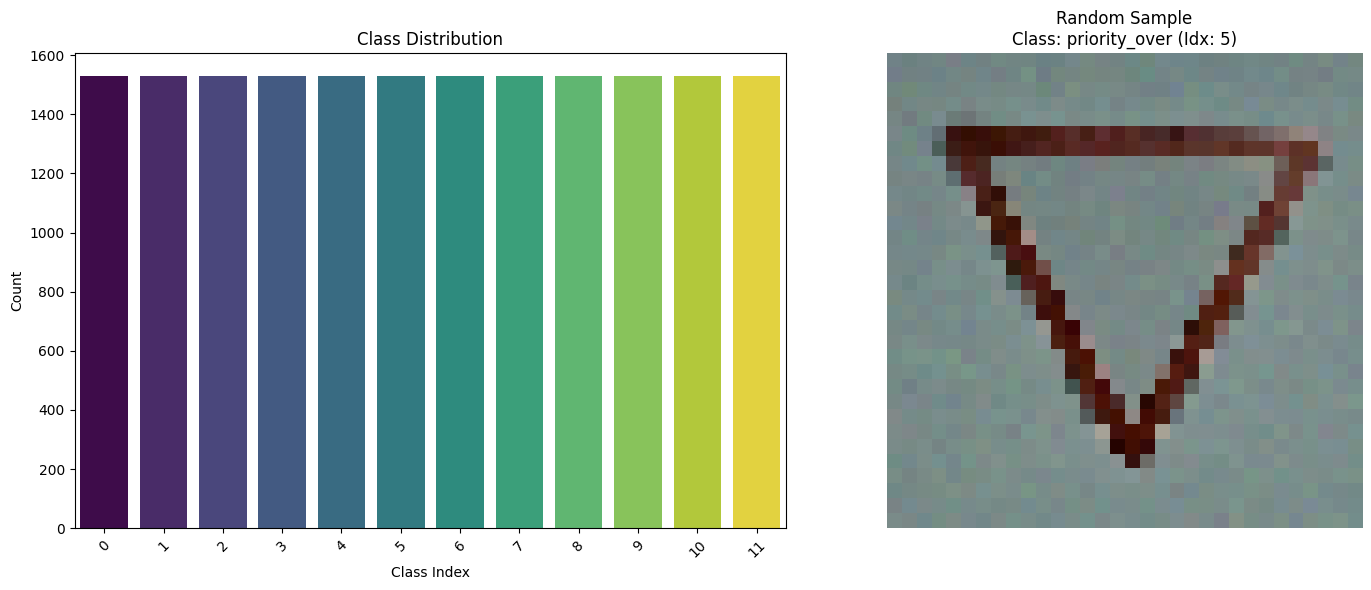

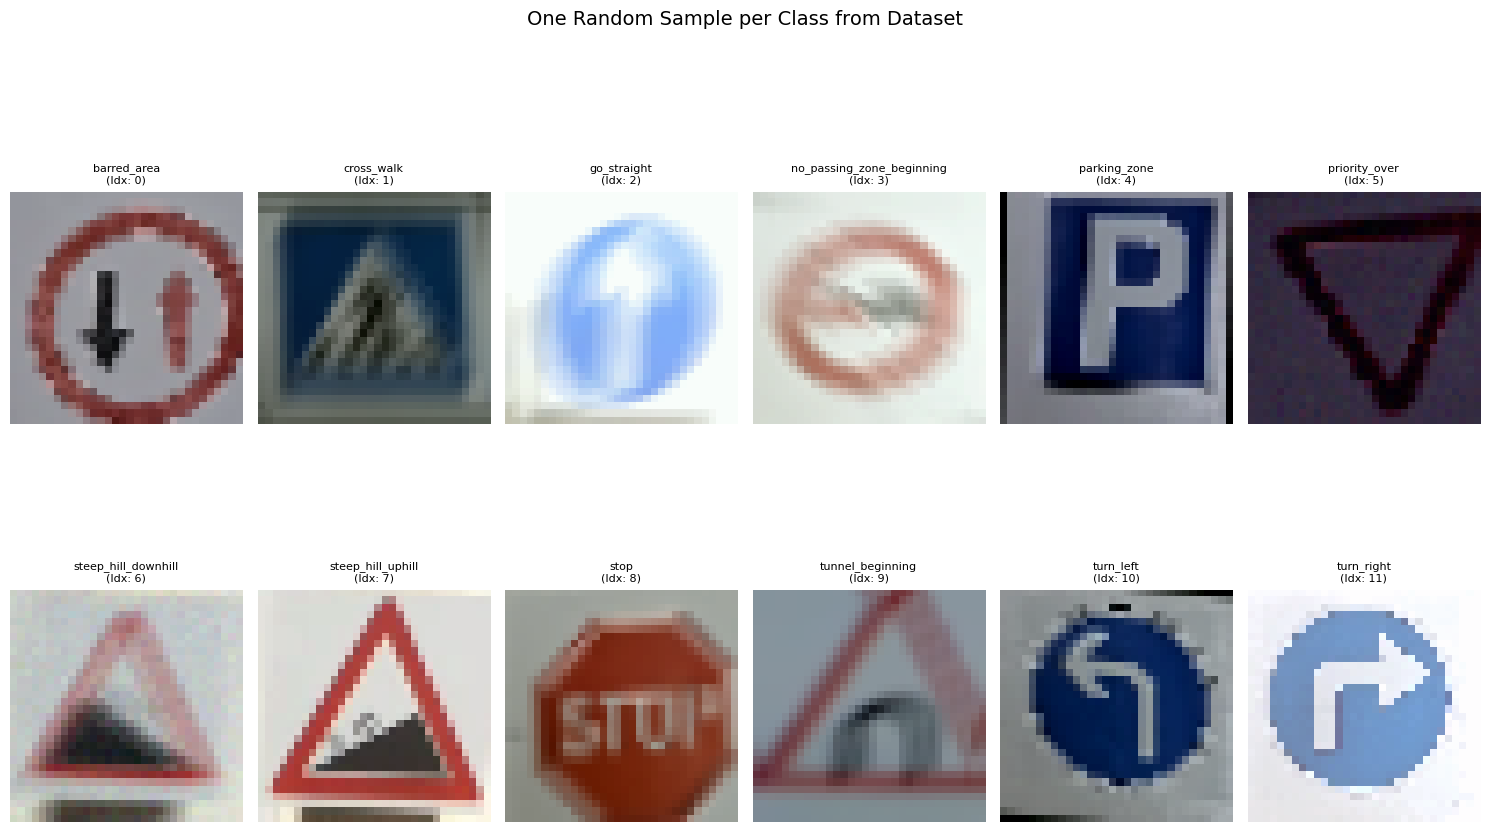

In [33]:
verify_dataset(train_dataset, class_names, mean=dataset_mean, std=dataset_std)


Class Distribution Details:
barred_area (Index 0): 369 samples
cross_walk (Index 1): 369 samples
go_straight (Index 2): 369 samples
no_passing_zone_beginning (Index 3): 369 samples
parking_zone (Index 4): 369 samples
priority_over (Index 5): 369 samples
steep_hill_downhill (Index 6): 369 samples
steep_hill_uphill (Index 7): 369 samples
stop (Index 8): 369 samples
tunnel_beginning (Index 9): 369 samples
turn_left (Index 10): 369 samples
turn_right (Index 11): 369 samples

Class Distribution Summary:
Total samples: 4428
Number of classes: 12
Mean samples per class: 369.0
Std samples per class: 0.0


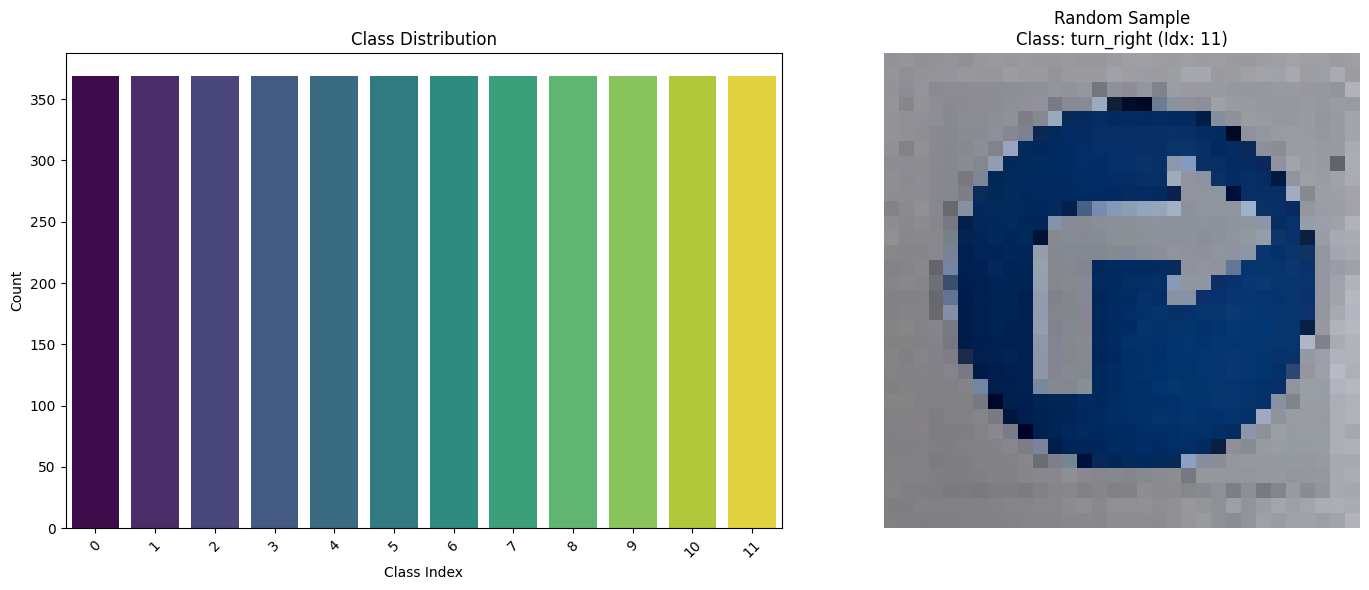

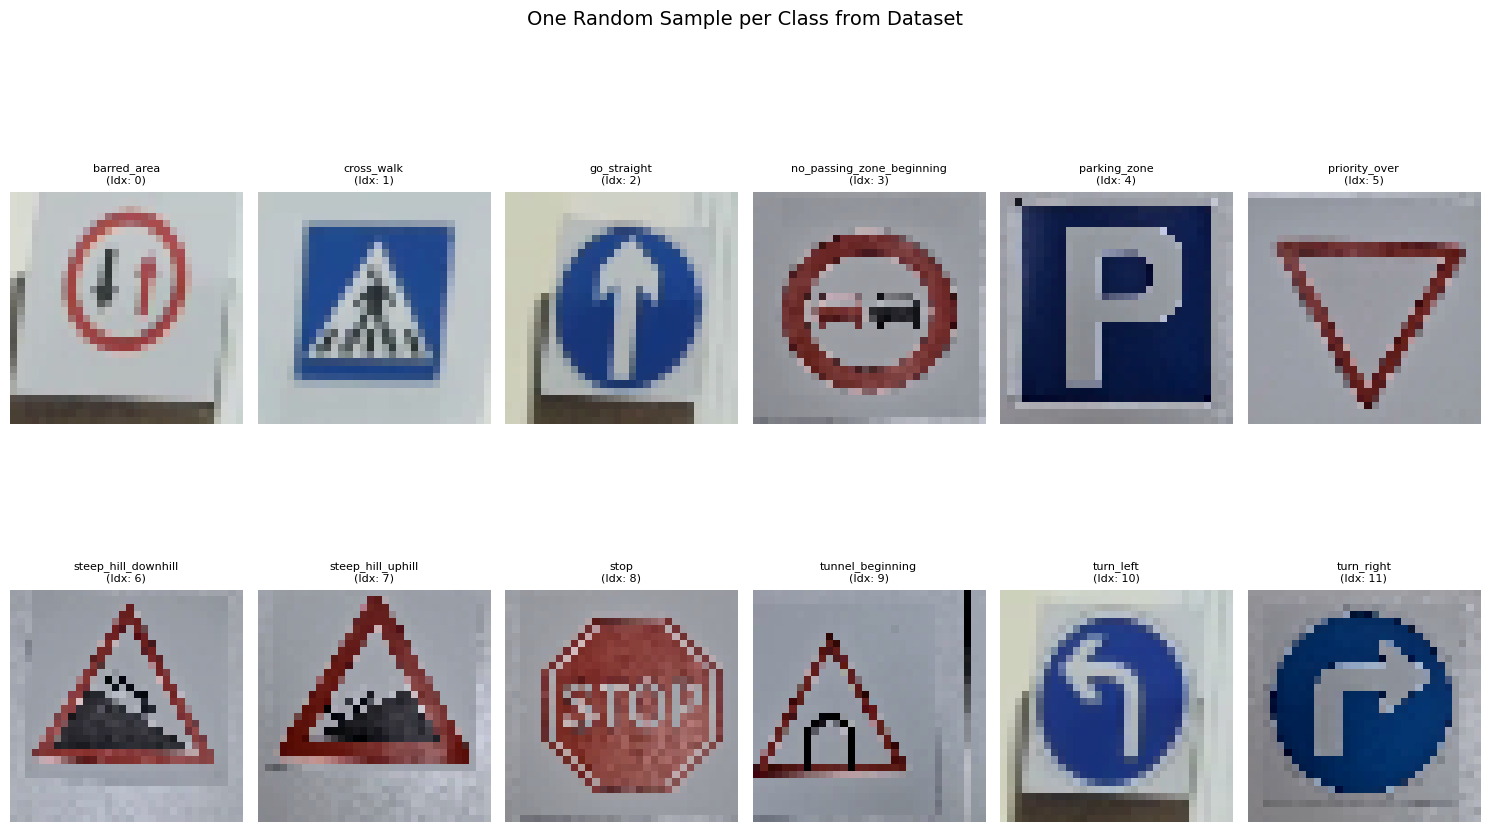

In [34]:
verify_dataset(test_dataset, class_names, mean=dataset_mean, std=dataset_std)


Class Distribution Details:
barred_area (Index 0): 75 samples
cross_walk (Index 1): 75 samples
go_straight (Index 2): 75 samples
no_passing_zone_beginning (Index 3): 75 samples
parking_zone (Index 4): 75 samples
priority_over (Index 5): 75 samples
steep_hill_downhill (Index 6): 75 samples
steep_hill_uphill (Index 7): 75 samples
stop (Index 8): 75 samples
tunnel_beginning (Index 9): 75 samples
turn_left (Index 10): 75 samples
turn_right (Index 11): 75 samples

Class Distribution Summary:
Total samples: 900
Number of classes: 12
Mean samples per class: 75.0
Std samples per class: 0.0


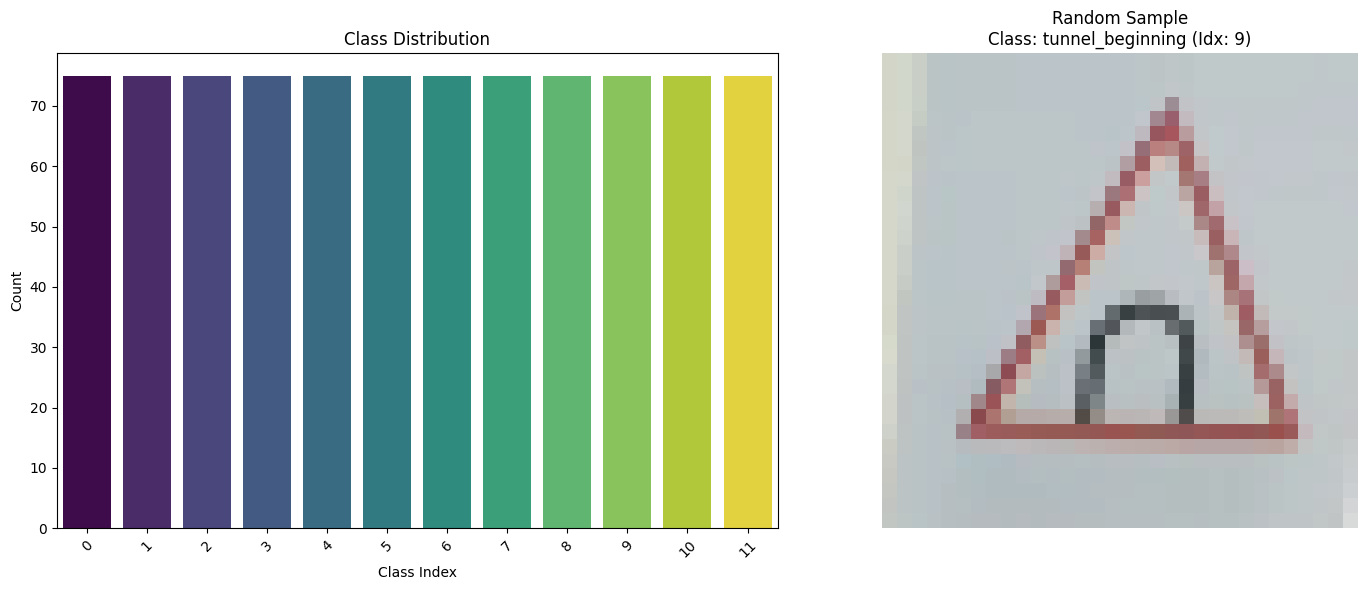

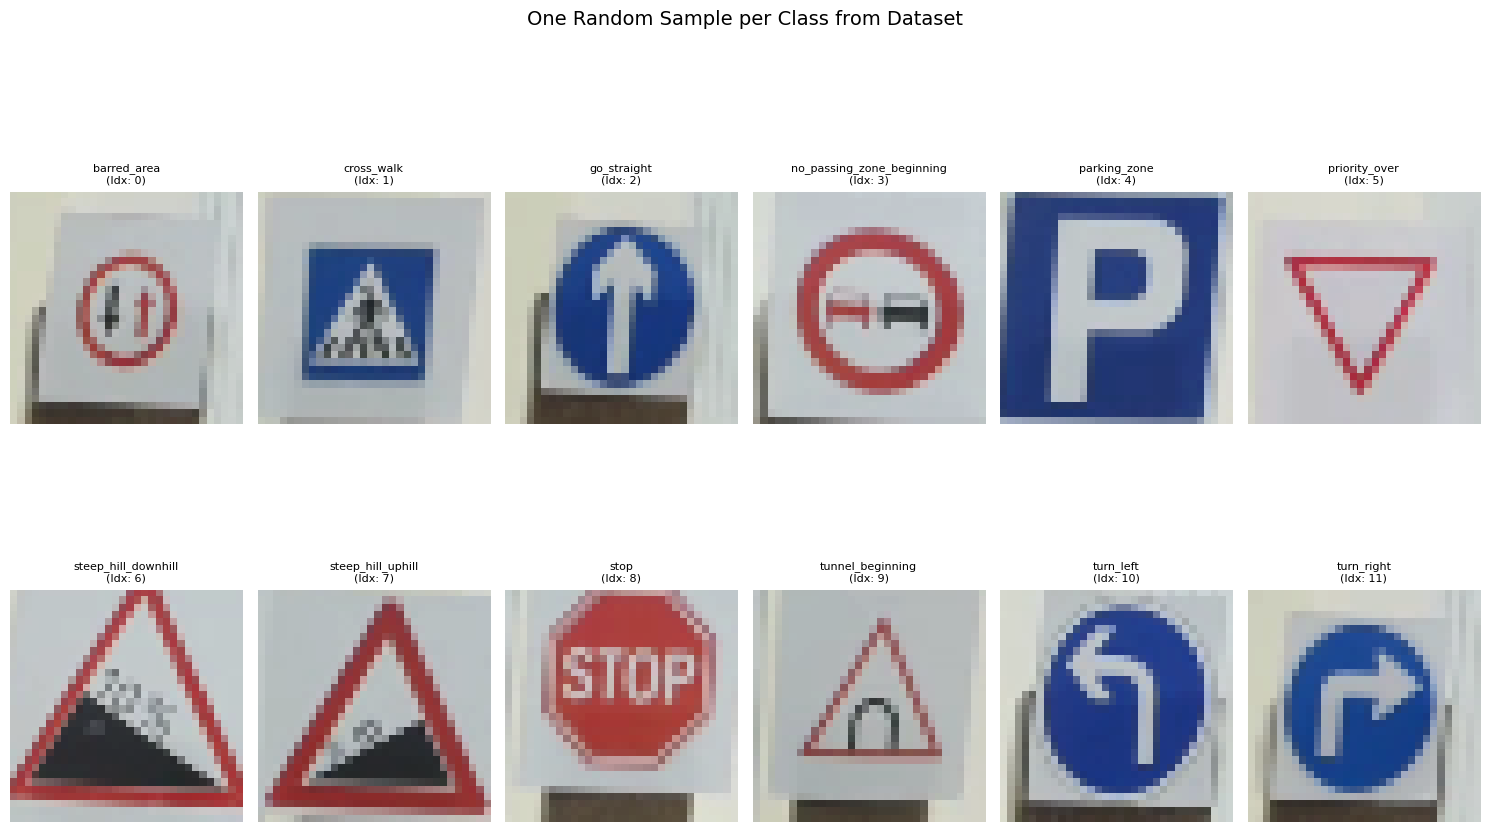

In [35]:
verify_dataset(val_dataset, class_names, mean=dataset_mean, std=dataset_std)

# Model

In [2]:
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

### Dataloader

In [8]:
root_dir = r'Dataset'
root_dir_model = r'TrainedModels'

In [9]:
X_train = np.load(os.path.join(root_dir, 'X_train_data.npy'))
y_train = np.load(os.path.join(root_dir, 'y_train_labels.npy'))

X_test  = np.load(os.path.join(root_dir, 'X_test_data.npy'))
y_test  = np.load(os.path.join(root_dir, 'y_test_labels.npy'))

X_val  = np.load(os.path.join(root_dir, 'X_val_data.npy'))
y_val  = np.load(os.path.join(root_dir, 'y_val_labels.npy'))

In [10]:
y_train = np.argmax(y_train, axis=1)
y_test  = np.argmax(y_test, axis=1)
y_val  = np.argmax(y_val, axis=1)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()

X_val  = torch.from_numpy(X_val).float()
y_val  = torch.from_numpy(y_val).long()

In [11]:
train_dataset_Tensor = TensorDataset(X_train, y_train)
test_dataset_Tensor = TensorDataset(X_test, y_test)
val_dataset_Tensor = TensorDataset(X_val, y_val)

In [12]:
batch_size = 64

train_loader = DataLoader(
    dataset=train_dataset_Tensor,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )

test_loader  = DataLoader(
    dataset=test_dataset_Tensor,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

val_loader  = DataLoader(
    dataset=val_dataset_Tensor,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

### CNN Model

In [3]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(TrafficSignCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten_dim = 64 * 8 * 8
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        logics = self.fc2(x)
        # F.softmax(logics, dim=1)
        
        return logics

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TrafficSignCNN(num_classes=12).to(device)
summary(model, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max',factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-8)

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
            Conv2d-2           [-1, 32, 32, 32]          25,632
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
            Conv2d-6           [-1, 64, 16, 16]          36,928
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 256]       1,048,832
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 12]           3,084
Total params: 1,135,404
Trainable params: 1,135,404
Non-trainable params: 0
----------------------------------------------------------------
Input s

### Training

In [45]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [46]:
epochs = 32
best_acc = 0.0

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
print("Training the model...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    epoch_start = time.time()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
    
    scheduler.step(val_acc)
    
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")
    
    if (val_acc >= best_acc):
        best_acc = val_acc
        model_save_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V06.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model updated and saved with val_accuracy = {val_acc:.4f}")
        print(f"Current val_acc = {val_acc:.4f}, Best val_acc = {best_acc:.4f}")
    else:
        print(f"Model not improved. Best val_accuracy remains at {best_acc:.4f}")
    
    epoch_duration = time.time() - epoch_start
    remaining_time = (epochs - epoch - 1) * epoch_duration
    print(f"Epoch {epoch+1}/{epochs}: loss={epoch_loss:.4f}, accuracy={epoch_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}")
    print(f"Epoch time: {epoch_duration:.2f}s, estimated remaining: {remaining_time:.2f}s\n")
    
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

print("\nExporting model to ONNX format...")
try:
    example_input = torch.randn(1, 3, 32, 32).to(device)
    model.eval()
    torch.onnx.export(
        model, 
        (example_input,), 
        os.path.join(root_dir_model, 'traffic_sign_cnn_V06.onnx'),
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        opset_version=13,
        verbose=False
    )
    print("Successfully exported ONNX model to:", os.path.join(root_dir_model, 'traffic_sign_cnn_V06.onnx'))
except Exception as e:
    print(f"Error exporting ONNX model: {e}")

model_save_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V06_F.pth')
torch.save(model.state_dict(), model_save_path)
print("Saved PyTorch model to:", model_save_path)

history_df = pd.DataFrame(history)
history_save_path = os.path.join(root_dir_model, 'historyV06.csv')
history_df.to_csv(history_save_path, index=False)
print("Saved training history to:", history_save_path)

Training the model...


Epoch 1/32: 100%|██████████| 287/287 [00:04<00:00, 66.42batch/s, loss=1.95]


Current learning rate: 0.001
Best model updated and saved with val_accuracy = 0.7467
Current val_acc = 0.7467, Best val_acc = 0.7467
Epoch 1/32: loss=2.0742, accuracy=0.5446, val_loss=1.8720, val_accuracy=0.7467
Epoch time: 4.41s, estimated remaining: 136.56s



Epoch 2/32: 100%|██████████| 287/287 [00:03<00:00, 79.61batch/s, loss=1.85]


Current learning rate: 0.001
Best model updated and saved with val_accuracy = 0.9111
Current val_acc = 0.9111, Best val_acc = 0.9111
Epoch 2/32: loss=1.8106, accuracy=0.8084, val_loss=1.7074, val_accuracy=0.9111
Epoch time: 3.67s, estimated remaining: 110.21s



Epoch 3/32: 100%|██████████| 287/287 [00:03<00:00, 79.30batch/s, loss=1.71]


Current learning rate: 0.001
Best model updated and saved with val_accuracy = 0.9144
Current val_acc = 0.9144, Best val_acc = 0.9144
Epoch 3/32: loss=1.7584, accuracy=0.8602, val_loss=1.7043, val_accuracy=0.9144
Epoch time: 3.69s, estimated remaining: 106.95s



Epoch 4/32: 100%|██████████| 287/287 [00:03<00:00, 79.30batch/s, loss=1.65]


Current learning rate: 0.001
Best model updated and saved with val_accuracy = 0.9933
Current val_acc = 0.9933, Best val_acc = 0.9933
Epoch 4/32: loss=1.7075, accuracy=0.9114, val_loss=1.6256, val_accuracy=0.9933
Epoch time: 3.69s, estimated remaining: 103.30s



Epoch 5/32: 100%|██████████| 287/287 [00:03<00:00, 79.35batch/s, loss=1.66]


Current learning rate: 0.001
Best model updated and saved with val_accuracy = 0.9978
Current val_acc = 0.9978, Best val_acc = 0.9978
Epoch 5/32: loss=1.6758, accuracy=0.9430, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.69s, estimated remaining: 99.61s



Epoch 6/32: 100%|██████████| 287/287 [00:03<00:00, 79.44batch/s, loss=1.69]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 6/32: loss=1.6861, accuracy=0.9327, val_loss=1.6221, val_accuracy=0.9967
Epoch time: 3.67s, estimated remaining: 95.52s



Epoch 7/32: 100%|██████████| 287/287 [00:03<00:00, 79.29batch/s, loss=1.65]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 7/32: loss=1.6808, accuracy=0.9377, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.68s, estimated remaining: 92.06s



Epoch 8/32: 100%|██████████| 287/287 [00:03<00:00, 79.29batch/s, loss=1.65]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 8/32: loss=1.6820, accuracy=0.9366, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.68s, estimated remaining: 88.37s



Epoch 9/32: 100%|██████████| 287/287 [00:03<00:00, 79.64batch/s, loss=1.65]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 9/32: loss=1.6787, accuracy=0.9399, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.67s, estimated remaining: 84.33s



Epoch 10/32: 100%|██████████| 287/287 [00:03<00:00, 79.38batch/s, loss=1.67]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 10/32: loss=1.6955, accuracy=0.9233, val_loss=1.6269, val_accuracy=0.9922
Epoch time: 3.68s, estimated remaining: 80.89s



Epoch 11/32: 100%|██████████| 287/287 [00:03<00:00, 79.04batch/s, loss=1.69]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 11/32: loss=1.7245, accuracy=0.8941, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.69s, estimated remaining: 77.53s



Epoch 12/32: 100%|██████████| 287/287 [00:03<00:00, 79.45batch/s, loss=1.64]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 12/32: loss=1.6822, accuracy=0.9365, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.67s, estimated remaining: 73.49s



Epoch 13/32: 100%|██████████| 287/287 [00:03<00:00, 79.02batch/s, loss=1.65]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 13/32: loss=1.6616, accuracy=0.9570, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.69s, estimated remaining: 70.16s



Epoch 14/32: 100%|██████████| 287/287 [00:03<00:00, 79.25batch/s, loss=1.64]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 14/32: loss=1.6556, accuracy=0.9631, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.68s, estimated remaining: 66.28s



Epoch 15/32: 100%|██████████| 287/287 [00:03<00:00, 79.43batch/s, loss=1.69]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 15/32: loss=1.6477, accuracy=0.9710, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.68s, estimated remaining: 62.49s



Epoch 16/32: 100%|██████████| 287/287 [00:03<00:00, 78.46batch/s, loss=1.64]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.9978
Epoch 16/32: loss=1.6458, accuracy=0.9728, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.73s, estimated remaining: 59.62s



Epoch 17/32: 100%|██████████| 287/287 [00:03<00:00, 78.67batch/s, loss=1.64]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.9978
Epoch 17/32: loss=1.6444, accuracy=0.9742, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.71s, estimated remaining: 55.68s



Epoch 18/32: 100%|██████████| 287/287 [00:03<00:00, 79.76batch/s, loss=1.69]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.9978
Epoch 18/32: loss=1.6435, accuracy=0.9751, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.66s, estimated remaining: 51.23s



Epoch 19/32: 100%|██████████| 287/287 [00:03<00:00, 79.96batch/s, loss=1.64]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.9978
Epoch 19/32: loss=1.6434, accuracy=0.9753, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.65s, estimated remaining: 47.44s



Epoch 20/32: 100%|██████████| 287/287 [00:03<00:00, 79.83batch/s, loss=1.62]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.9978
Epoch 20/32: loss=1.6427, accuracy=0.9763, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.66s, estimated remaining: 43.89s



Epoch 21/32: 100%|██████████| 287/287 [00:03<00:00, 79.82batch/s, loss=1.66]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.9978
Epoch 21/32: loss=1.6423, accuracy=0.9765, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.66s, estimated remaining: 40.21s



Epoch 22/32: 100%|██████████| 287/287 [00:03<00:00, 79.83batch/s, loss=1.64]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.9978
Epoch 22/32: loss=1.6422, accuracy=0.9764, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.66s, estimated remaining: 36.59s



Epoch 23/32: 100%|██████████| 287/287 [00:03<00:00, 79.81batch/s, loss=1.64]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.9978
Epoch 23/32: loss=1.6418, accuracy=0.9769, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.66s, estimated remaining: 32.92s



Epoch 24/32: 100%|██████████| 287/287 [00:03<00:00, 79.33batch/s, loss=1.67]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.9978
Epoch 24/32: loss=1.6424, accuracy=0.9762, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.68s, estimated remaining: 29.44s



Epoch 25/32: 100%|██████████| 287/287 [00:03<00:00, 79.90batch/s, loss=1.64]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.9978
Epoch 25/32: loss=1.6439, accuracy=0.9748, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.66s, estimated remaining: 25.59s



Epoch 26/32: 100%|██████████| 287/287 [00:03<00:00, 79.99batch/s, loss=1.65]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.9978
Epoch 26/32: loss=1.6418, accuracy=0.9768, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.65s, estimated remaining: 21.90s



Epoch 27/32: 100%|██████████| 287/287 [00:03<00:00, 79.62batch/s, loss=1.65]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.9978
Epoch 27/32: loss=1.6432, accuracy=0.9754, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.67s, estimated remaining: 18.33s



Epoch 28/32: 100%|██████████| 287/287 [00:03<00:00, 80.06batch/s, loss=1.64]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.9978
Epoch 28/32: loss=1.6426, accuracy=0.9761, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.65s, estimated remaining: 14.59s



Epoch 29/32: 100%|██████████| 287/287 [00:03<00:00, 80.64batch/s, loss=1.62]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.9978
Epoch 29/32: loss=1.6407, accuracy=0.9780, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.62s, estimated remaining: 10.86s



Epoch 30/32: 100%|██████████| 287/287 [00:03<00:00, 79.89batch/s, loss=1.64]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.9978
Epoch 30/32: loss=1.6419, accuracy=0.9768, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.65s, estimated remaining: 7.31s



Epoch 31/32: 100%|██████████| 287/287 [00:03<00:00, 79.30batch/s, loss=1.67]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.9978
Epoch 31/32: loss=1.6413, accuracy=0.9773, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.68s, estimated remaining: 3.68s



Epoch 32/32: 100%|██████████| 287/287 [00:03<00:00, 80.08batch/s, loss=1.65]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.9978
Epoch 32/32: loss=1.6413, accuracy=0.9775, val_loss=1.6210, val_accuracy=0.9978
Epoch time: 3.64s, estimated remaining: 0.00s

Test Loss: 1.6194, Test Accuracy: 99.93%

Exporting model to ONNX format...
Successfully exported ONNX model to: TrainedModels\traffic_sign_cnn_V06.onnx
Saved PyTorch model to: TrainedModels\traffic_sign_cnn_V06_F.pth
Saved training history to: TrainedModels\historyV06.csv


# Eval

In [4]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

----------- Starting Model Evaluation -----------
Loading preprocessed test data...
Loading model...
Evaluating model on test data...
Test Loss: 0.1116, Test Accuracy: 99.93%
Loading training history...


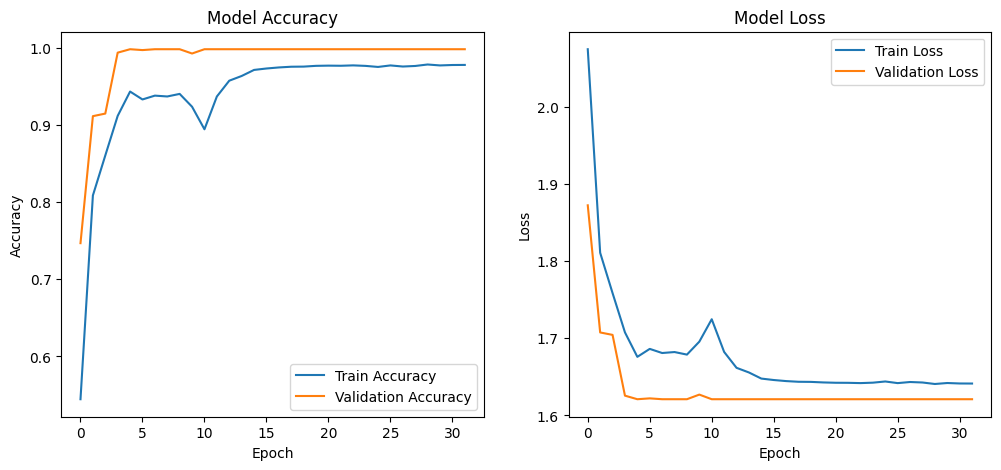

----------- Model Evaluation Complete -----------


In [5]:
root_dir = r'Dataset'
root_dir_model = r'TrainedModels'
batch_size = 64

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print("----------- Starting Model Evaluation -----------")
print("Loading preprocessed test data...")

X_test = np.load(os.path.join(root_dir, 'X_test_data.npy'))
y_test = np.load(os.path.join(root_dir, 'y_test_labels.npy'))

y_test = np.argmax(y_test, axis=1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Loading model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignCNN(num_classes=12).to(device)
model_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V06.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

criterion = nn.CrossEntropyLoss()

print("Evaluating model on test data...")
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

history_path = os.path.join(root_dir_model, 'historyV06.csv')
if os.path.exists(history_path):
    print("Loading training history...")
    history_df = pd.read_csv(history_path)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Train Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Train Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

print("----------- Model Evaluation Complete -----------")

In [13]:
def predict_sample(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
    return pred, prob.cpu().numpy()

print("\nSample validation predictions:")
num_samples = 10
indices = np.random.choice(len(val_dataset_Tensor), num_samples, replace=False)
for idx in indices:
    img, label = val_dataset_Tensor[idx]
    pred, prob = predict_sample(model, img)
    print(f"Sample index {idx}: Ground truth: {label.item()}, Prediction: {pred}")



Sample validation predictions:
Sample index 360: Ground truth: 4, Prediction: 4
Sample index 740: Ground truth: 9, Prediction: 9
Sample index 618: Ground truth: 8, Prediction: 8
Sample index 372: Ground truth: 4, Prediction: 4
Sample index 759: Ground truth: 10, Prediction: 10
Sample index 7: Ground truth: 0, Prediction: 0
Sample index 524: Ground truth: 6, Prediction: 6
Sample index 553: Ground truth: 7, Prediction: 6
Sample index 826: Ground truth: 11, Prediction: 11
Sample index 529: Ground truth: 7, Prediction: 7


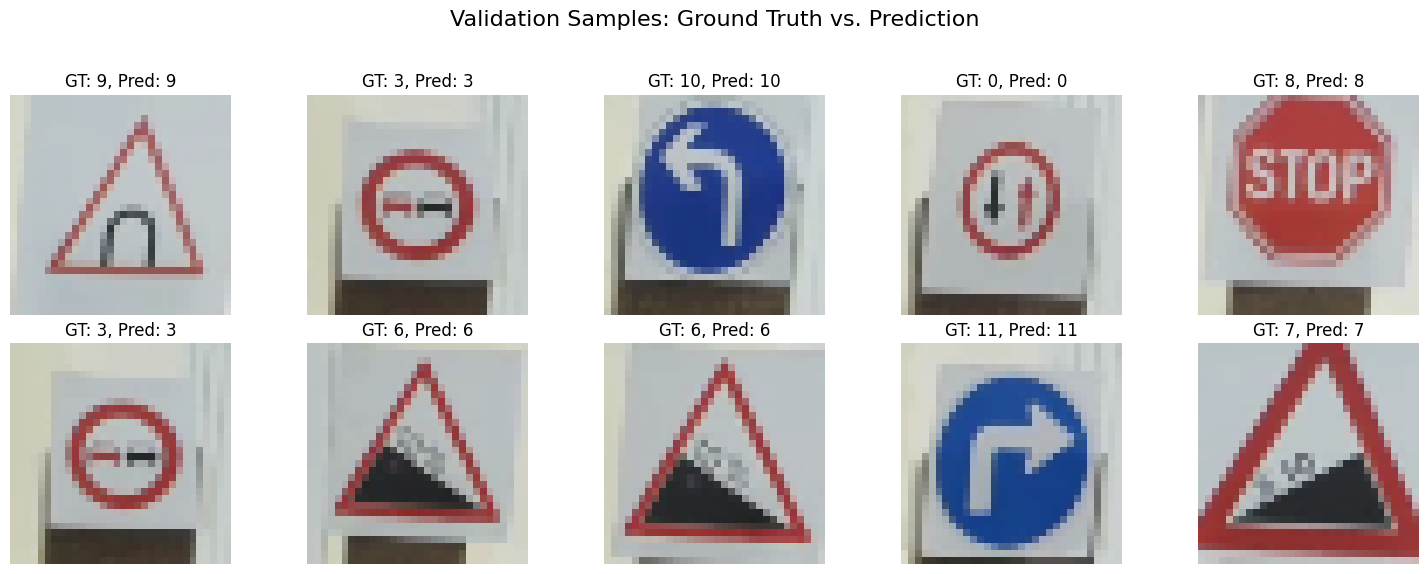

In [16]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.choice(len(val_dataset_Tensor), 10, replace=False)):
    img, label = val_dataset_Tensor[idx]
    pred, _ = predict_sample(model, img)
    img_disp = denormalize_image(img, dataset_mean, dataset_std)
    plt.subplot(2, 5, i+1)
    plt.imshow(img_disp)
    plt.title(f"GT: {label.item()}, Pred: {pred}")
    plt.axis("off")
plt.suptitle("Validation Samples: Ground Truth vs. Prediction", fontsize=16)
plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = os.path.join(r'TrainedModels', 'traffic_sign_cnn_V06_F.pth')
model = TrafficSignCNN(num_classes=12).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

TrafficSignCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=12, bias=True)
)

In [19]:
def evaluate_model_full(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    total = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)  # raw logits
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
    
    avg_loss = running_loss / total
    accuracy = accuracy_score(all_labels, all_preds)
    
    top3_correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Get top 3 predictions
            topk_values, topk_preds = torch.topk(outputs, 3, dim=1)
            # Compare if true label is among top 3
            for i in range(labels.size(0)):
                if labels[i] in topk_preds[i]:
                    top3_correct += 1
    top3_accuracy = top3_correct / total

    return avg_loss, accuracy, all_preds, all_labels, top3_accuracy

In [20]:
test_loss, test_acc, preds, true_labels, top3_acc = evaluate_model_full(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Top-3 Accuracy: {top3_acc * 100:.2f}%")

Evaluating: 100%|██████████| 70/70 [00:00<00:00, 104.61batch/s]



Test Loss: 0.6439
Test Accuracy: 99.93%
Test Top-3 Accuracy: 99.93%


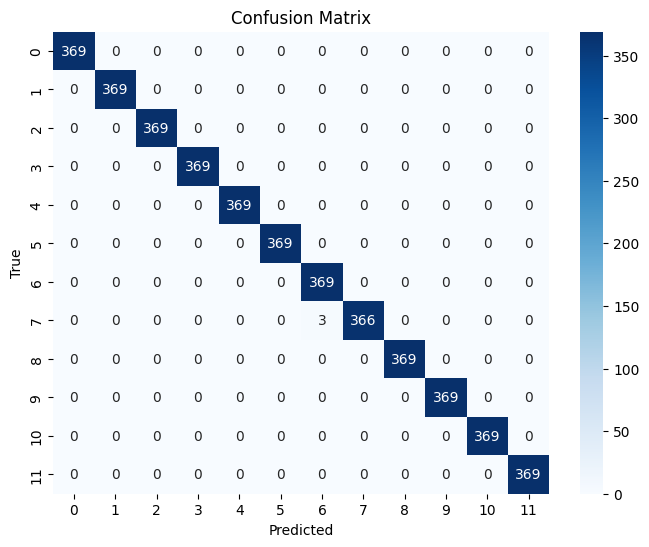

In [ ]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [22]:
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=[f"Class {i}" for i in range(12)]))


Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       369
     Class 1       1.00      1.00      1.00       369
     Class 2       1.00      1.00      1.00       369
     Class 3       1.00      1.00      1.00       369
     Class 4       1.00      1.00      1.00       369
     Class 5       1.00      1.00      1.00       369
     Class 6       0.99      1.00      1.00       369
     Class 7       1.00      0.99      1.00       369
     Class 8       1.00      1.00      1.00       369
     Class 9       1.00      1.00      1.00       369
    Class 10       1.00      1.00      1.00       369
    Class 11       1.00      1.00      1.00       369

    accuracy                           1.00      4428
   macro avg       1.00      1.00      1.00      4428
weighted avg       1.00      1.00      1.00      4428



In [23]:
val_loss, val_acc, val_preds, val_true_labels, val_top3_acc = evaluate_model_full(model, val_loader, device)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Top-3 Accuracy: {val_top3_acc * 100:.2f}%")

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 38.79batch/s]



Validation Loss: 2.1274
Validation Accuracy: 99.78%
Validation Top-3 Accuracy: 99.78%


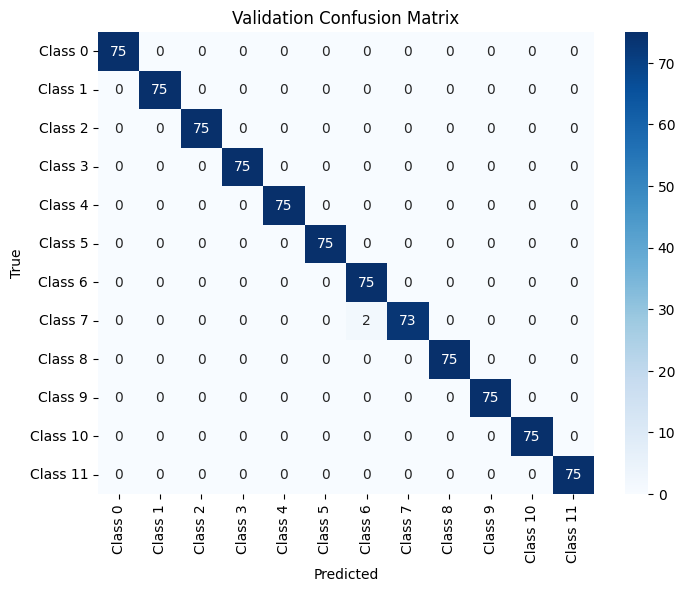

In [24]:
cm_val = confusion_matrix(val_true_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(12)],
            yticklabels=[f"Class {i}" for i in range(12)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()

In [25]:
print("\nValidation Classification Report:")
print(classification_report(val_true_labels, val_preds, target_names=[f"Class {i}" for i in range(12)]))


Validation Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        75
     Class 1       1.00      1.00      1.00        75
     Class 2       1.00      1.00      1.00        75
     Class 3       1.00      1.00      1.00        75
     Class 4       1.00      1.00      1.00        75
     Class 5       1.00      1.00      1.00        75
     Class 6       0.97      1.00      0.99        75
     Class 7       1.00      0.97      0.99        75
     Class 8       1.00      1.00      1.00        75
     Class 9       1.00      1.00      1.00        75
    Class 10       1.00      1.00      1.00        75
    Class 11       1.00      1.00      1.00        75

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

